# Trabajo Práctico 2: Filtrado lineal óptimo
Pablo González Leiro

Septiembre 2022

In [1]:
import scipy
from scipy.fft import fft, fftshift, fftfreq
import numpy as np
from matplotlib import pyplot as plt
from playsound import playsound

## Setup
<a href="https://productz.com/en/logitech-x50/p/KZ6Z">Parlante Logitech X50</a>

<table>
<tr><td colspan=2>Especificaciones Logitech X50</td></tr>
<tr><td>Canales</td><td>1</td></tr>
<tr><td>Frecuencia más baja</td><td>130 Hz</td></tr>
<tr><td>Frecuencia más alta</td><td>20000 Hz</td></tr>
<tr><td>Potencia RMS</td><td>3W</td></tr>
<tr><td>Potencia pico</td><td>3W</td></tr>
</tr>
</table>

Las grabaciones fueron hechas usando un iPhone XS y la aplicación [Auphonic Recorder](https://apps.apple.com/us/app/auphonic-recorder/id1081792712), con la que se configuró:
- iPhone Microphone (Bottom). La otras opciones eran Front y Back.
- Formato CAF (Core Audio Format), que es similar a WAV (Waveform Audio Format)
- Frecuencia de muestreo 48000 Hz
- 1 Canal (Mono)
- 16 bits de precisión

Las grabaciones luego fueron convertidas de .caf a .wav usando el comando:
```
ffmpeg -i input.caf output.wav
```

In [2]:
""" Signal parameters """
fs = 48000
n_sec = 10
amplitude = np.iinfo(np.int16).max

""" Plot parameters """
figsize = (3.2, 2.4)

In [3]:
def periodogram(x, N=2**20, Fs=fs):
    sp = fftshift(fft(x=x, n=N))
    freq = fftshift(fftfreq(n=N, d=1/Fs))
    Pxx = np.abs(sp)**2 / N
    return freq, Pxx

def periodogram_averaging(x, N, L, D):
    periodograms = []
    i = 0
    while i < (N-D):
        window = scipy.signal.windows.tukey(L, alpha=0.5, sym=True)
        data = x[i:i+L]
        data_windowed = np.multiply(window, data)
        freq, Pxx = periodogram(x=data_windowed, N=L)
        periodograms.append(Pxx)
        i = i + L - D
    K = len(periodograms)
    y = np.array([np.array(xi) for xi in periodograms])
    mean_periodogram = np.mean(a=y, axis=0)
    return freq, mean_periodogram, K

def plot_audio(
    x: np.array,
    fs: int, freq: np.array,
    Pxx: np.array,
    title: str,
    xlim: tuple = (0,10*fs)
    ) -> plt.Figure:

    fig = plt.figure(num=title, figsize=(10,3.2))
    ax1 = fig.add_subplot(1, 2, 1)
    ax1.plot(x)
    ax1.set_xlim(*xlim)
    ticks = np.linspace(xlim[0], xlim[1], 6)
    ax1.set_xticks(
        ticks=ticks,
        labels=[f"{i/fs}" for i in ticks]
    ) 
    #ax1.set_yticks(ticks=[-2**15,0,2**15-1], labels=[-2**15,0,2**15-1])
    ax1.set_title(title)
    ax1.set_ylabel("Amplitude @ 15 bits")
    ax1.set_xlabel("Time [s]")
    
    n = len(freq)
    ax2 = fig.add_subplot(1, 2, 2)
    ax2.loglog(freq[n//2:], Pxx[n//2:], nonpositive='clip')
    ax2.set_title(f"PSD {title}")
    ax2.set_xlim((2, fs//2))
    ax2.set_xticks(ticks=[2,20,200,2000,20000], labels=[2,20,200,2000,20000])
    ax2.set_xlabel("Frequency [Hz]")
    ax2.set_ylabel("Power [W]")
    for line in [130, 20000]:
        ax2.axvline(line, linestyle="dotted", color="k")
    
    plt.close()
    return fig

## 1. Generar las excitaciones $x_j(n)$ y grabar las señales $y_j(n)$

Para cada señal generada, se hizo una grabación manteniendo el setup inicial. Luego se realizó la conversión CAF a WAV, para poder trabajar con los datos en Python.

Para las señales de voz y música, usé un [conversor de YouTube a WAV](https://es.loader.to/1/youtube-wav-converter.html).

### 1. Señal de voz

Para cubrir el espectro audible lo mejor posible, elegí un audio con varias voces, masculinas y femeninas.

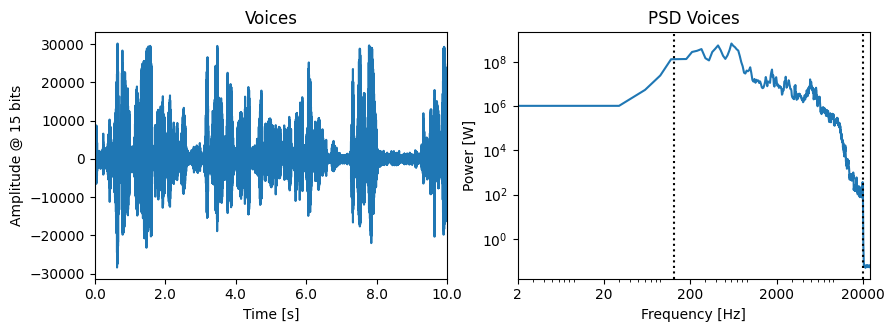

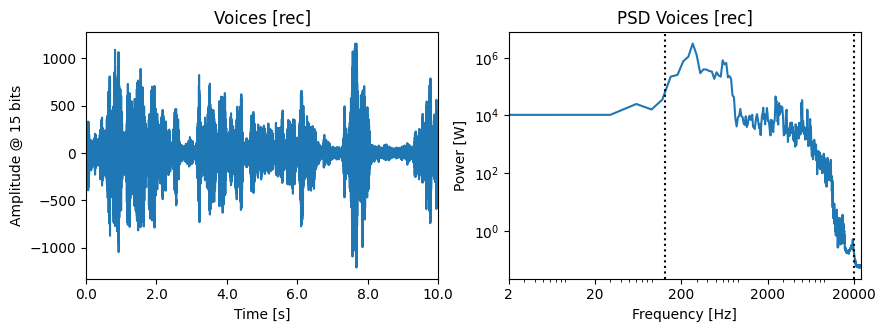

In [4]:
""" Original audio """
rate, data = scipy.io.wavfile.read(filename="audio/excitaciones/voices.wav")
offset = 20000
x1 = data[offset:offset+rate*10,1] # right

# Periodograma
N = len(x1)
L = N // 300
freq, Pxx, K = periodogram_averaging(x=x1, N=N, L=L, D=L//2)

scipy.io.wavfile.write("audio/excitaciones/voices_right.wav", rate, x1.astype(np.int16))
#sounddevice.play(x, rate)

figx1 = plot_audio(x1, rate, freq, Pxx, "Voices")


""" Audio recorded with the microphone """
rate_mic, data_mic = scipy.io.wavfile.read(filename="audio/recordings/voices_mic.wav")
offset = 76000 # a ojo
y1 = data_mic[offset:offset+10*rate_mic]

# Periodograma
N = len(y1)
L = N // 300
freq, Pxx, K = periodogram_averaging(x=y1, N=N, L=L, D=L//2)
figy1 = plot_audio(x=y1, fs=rate_mic, freq=freq, Pxx=Pxx, title="Voices [rec]")

display(figx1, figy1)


In [6]:
# Alineo a ojo
# o = 67000
# d = 20000
# plt.plot(data_mic[o+d:o+d+30000]); plt.show()
# plt.plot(x2[d:d+30000]); plt.show()

#sounddevice.play(data_mic[:13000] ,fs)

### 2. Señal de música

Elegí un fragmento solo con instrumentación (sin voz humana) ya que tenía la intuición de que así generaría un resultado distinto al del caso anterior. Además, investigué un poco sobre los distintos géneros musicales y su contenido espectral. Encontré que géneros como el Jazz tienden a tener máyor potencia en frecuencias medias, mientras que otros géneros como el hip-hop, el rock y el pop suelen tener máyor contenido en frecuencias bajas (<150Hz) y altas (>5000Hz).

Como mi parlante funciona entre 130 y 20000 Hz opté por usar un fragmento de Jazz, de la canción "New York, New York".

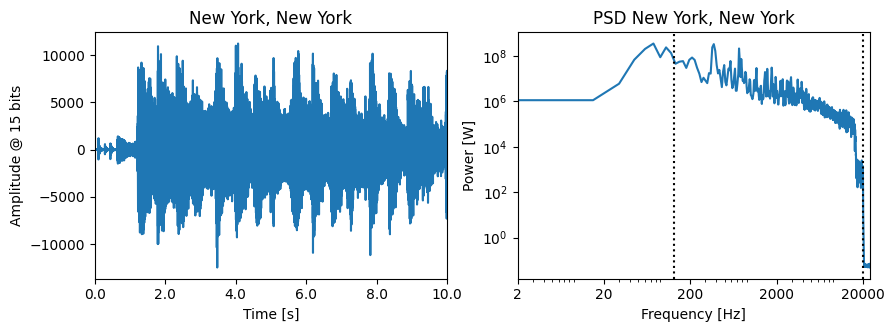

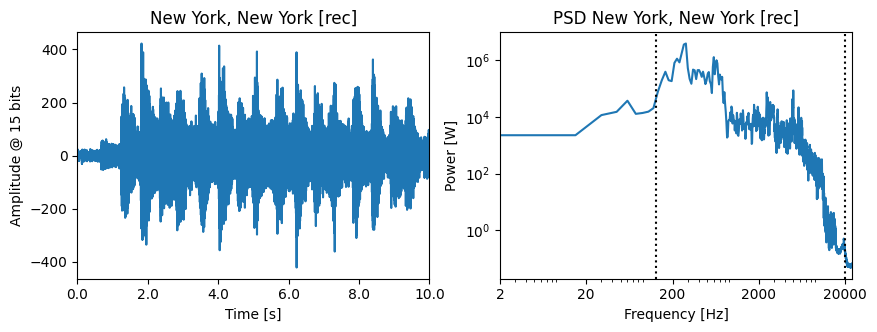

In [7]:
""" Original audio """
rate, data = scipy.io.wavfile.read(filename="audio/excitaciones/newyork.wav")
offset = 20000
x2 = data[offset:offset+rate*10,1] # right s

# Periodograma
N = len(x2)
L = N // 150
freq, Pxx, K = periodogram_averaging(x=x2, N=N, L=L, D=L//2)

scipy.io.wavfile.write("audio/excitaciones/newyork_right.wav", rate, x2.astype(np.int16))
#sounddevice.play(x, rate)

figx2 = plot_audio(x2, rate, freq, Pxx, "New York, New York")


""" Audio recorded with the microphone """
rate_mic, data_mic = scipy.io.wavfile.read(filename="audio/recordings/newyork_mic.wav")
offset = 67000 # a ojo
y2 = data_mic[offset:offset+10*rate_mic]

# Periodograma
N = len(y2)
L = N // 150
freq, Pxx, K = periodogram_averaging(x=y1, N=N, L=L, D=L//2)
figy2 = plot_audio(x=y2, fs=rate_mic, freq=freq, Pxx=Pxx, title="New York, New York [rec]")

display(figx2, figy2)

### 3. Square wave

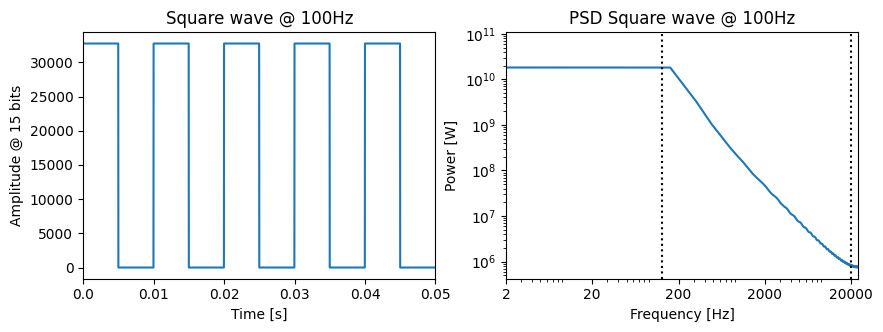

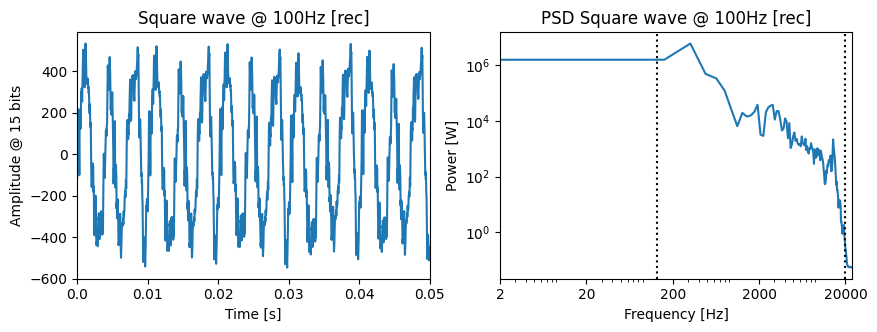

In [9]:
f = 100
""" Generate square wave
t = np.linspace(start=0, stop=n_sec, num=n_sec*fs)
x3 = amplitude//2 *( 1 + scipy.signal.square(2 * np.pi * f * t) )
scipy.io.wavfile.write("audio/generated/square_wave.wav", fs, x3.astype(np.int16))
"""
rate, x3 = scipy.io.wavfile.read("audio/excitaciones/square_wave.wav", fs)

# Periodograma
N = len(x3)
L = N // 1600
freq, Pxx, K = periodogram_averaging(x=x3, N=N, L=L, D=L//2)
figx3 = plot_audio(x3[:fs//20], fs, freq, Pxx, f"Square wave @ {f}Hz", xlim=(0,fs//20))

""" Audio recorded with the microphone """
rate_mic, data_mic = scipy.io.wavfile.read(filename="audio/recordings/square_wave_mic.wav")
offset = 41500 # a ojo
y3 = data_mic[offset:offset+10*rate_mic]

# Periodograma
N = len(y3)
L = N // 1600
freq, Pxx, K = periodogram_averaging(x=y3, N=N, L=L, D=L//2)
figy3 = plot_audio(x=y3[5*fs:5*fs+fs//20], fs=rate_mic, freq=freq, Pxx=Pxx, title=f"Square wave @ {f}Hz [rec]", xlim=(0, fs//20))

display(figx3, figy3)

### 4. Barrido lineal en frecuencia

https://www.linkedin.com/pulse/signal-analysis-ii-linear-vs-logarithmic-sine-sweep-william-fehlhaber/

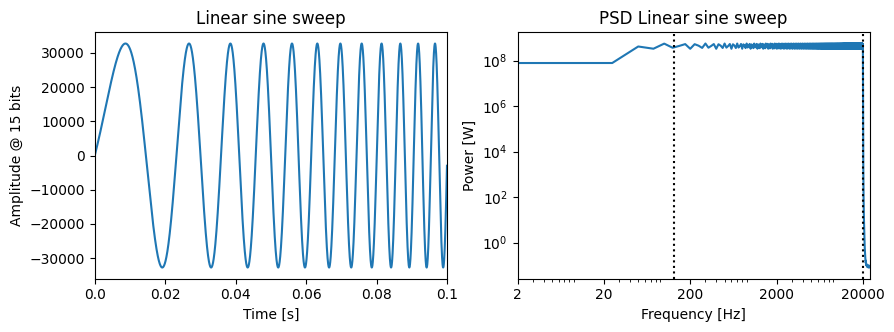

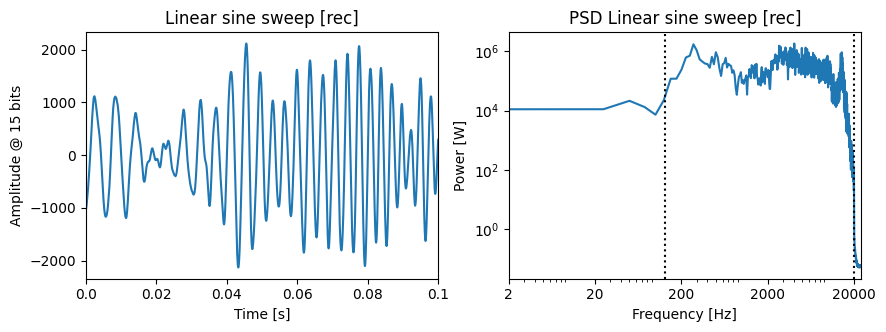

In [10]:
""" Generar barrido lineal
f0 = 20
f1 = 20000
T = n_sec
k = (f1 - f0) / T
t = np.linspace(start=0, stop=n_sec, num=n_sec*fs)
x4 = np.iinfo(np.int16).max * np.sin( 2*np.pi*f0*t + 2*np.pi*k*t**2/2  )
scipy.io.wavfile.write("audio/original/linear_sine_sweep.wav", fs, x4.astype(np.int16))
"""
fs, x4 = scipy.io.wavfile.read("audio/excitaciones/linear_sine_sweep.wav")

# Periodograma
N = len(x4)
L = N // 250
freq, Pxx, K = periodogram_averaging(x=x4, N=N, L=L, D=L//2)

figx4 = plot_audio(x4[:fs//10], fs, freq, Pxx, title="Linear sine sweep", xlim=(0,fs//10))

""" Audio recorded with the microphone """
rate_mic, data_mic = scipy.io.wavfile.read(filename="audio/recordings/linear_sine_sweep_mic.wav")
offset = 74500 # a ojo = 74500
y4 = data_mic[offset:offset+10*rate_mic]

# Periodograma
N = len(y4)
L = N // 250
freq, Pxx, K = periodogram_averaging(x=y4, N=N, L=L, D=L//2)
figy4 = plot_audio(x=y4[0:fs//10], fs=rate_mic, freq=freq, Pxx=Pxx, title="Linear sine sweep [rec]", xlim=(0,fs//10))


display(figx4, figy4)

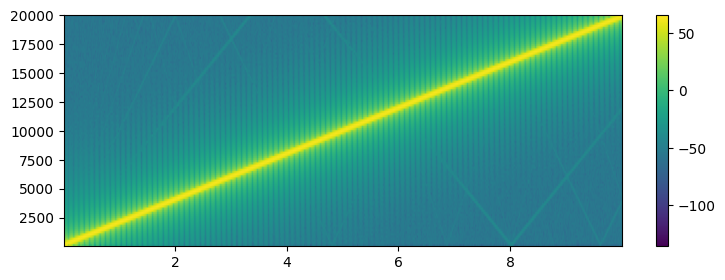

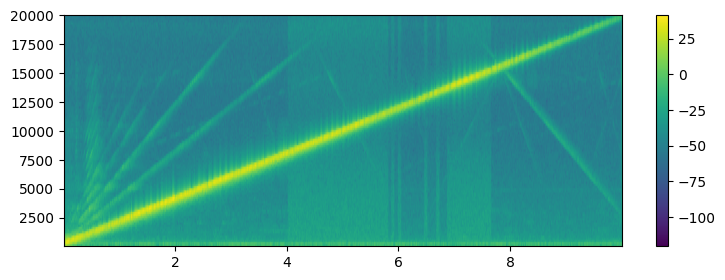

In [11]:
_ = plt.figure(figsize=(9,3)); plt.specgram(x4, Fs=fs); plt.colorbar(); plt.ylim(20,20e3); plt.show()
_ = plt.figure(figsize=(9,3)); plt.specgram(y4, Fs=fs); plt.colorbar(); plt.ylim(20,20e3); plt.show()

### 5. Barrido exponencial en frecuencia

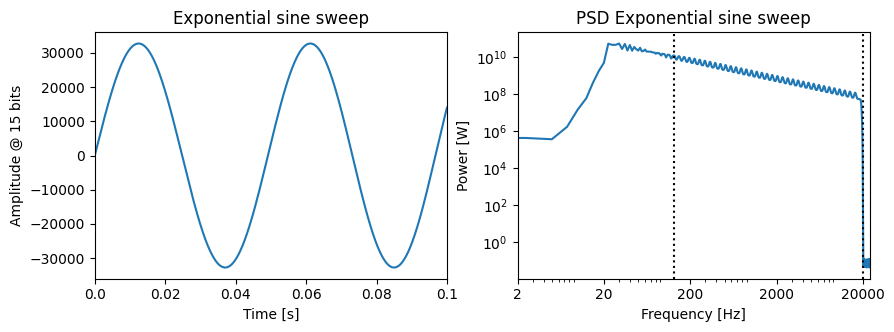

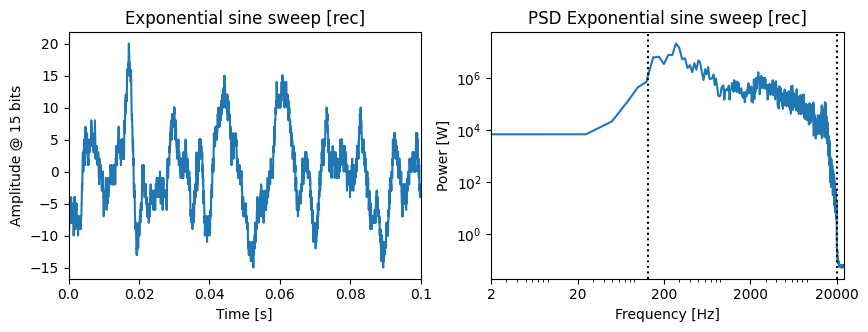

In [12]:
""" Generar barrido exponencial
f0 = 20
f1 = 20000
T = n_sec
k = (f1 / f0) ** (1 / T)
t = np.linspace(start=0, stop=n_sec, num=n_sec*fs)
x5 = np.iinfo(np.int16).max * np.sin( 2*np.pi*f0 * (k**t - 1) / (np.log(k)) )
scipy.io.wavfile.write("audio/generated/exp_sine_sweep.wav", fs, x5.astype(np.int16))
"""
fs, x5 = scipy.io.wavfile.read("audio/excitaciones/exp_sine_sweep.wav")

# Periodograma
N = len(x5)
L = N // 25
freq, Pxx, K = periodogram_averaging(x=x5, N=N, L=L, D=L//2)

figx5 = plot_audio(x5[:fs//10], fs, freq, Pxx, title="Exponential sine sweep", xlim=(0,fs//10))

""" Audio recorded with the microphone """
rate_mic, data_mic = scipy.io.wavfile.read(filename="audio/recordings/exp_sine_sweep_mic.wav")
offset = 44000 # por iteraciones
y5 = data_mic[offset:offset+10*rate_mic]

# Periodograma
N = len(y5)
L = N // 250
freq, Pxx, K = periodogram_averaging(x=y5, N=N, L=L, D=L//2)
figy5 = plot_audio(x=y5[:fs//10], fs=rate_mic, freq=freq, Pxx=Pxx, title="Exponential sine sweep [rec]", xlim=(0,fs//10))


display(figx5, figy5)

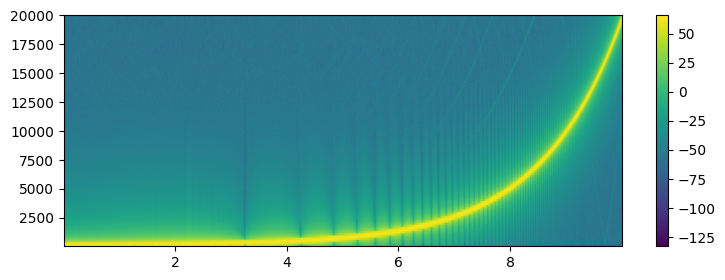

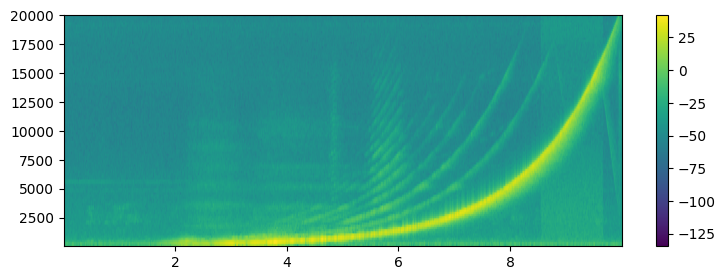

In [13]:
_ = plt.figure(figsize=(9,3)); plt.specgram(x5, Fs=fs); plt.colorbar(); plt.ylim(20,20e3); plt.show()
_ = plt.figure(figsize=(9,3)); plt.specgram(y5, Fs=fs); plt.colorbar(); plt.ylim(20,20e3); plt.show()

### Ruido blanco gaussiano de media cero

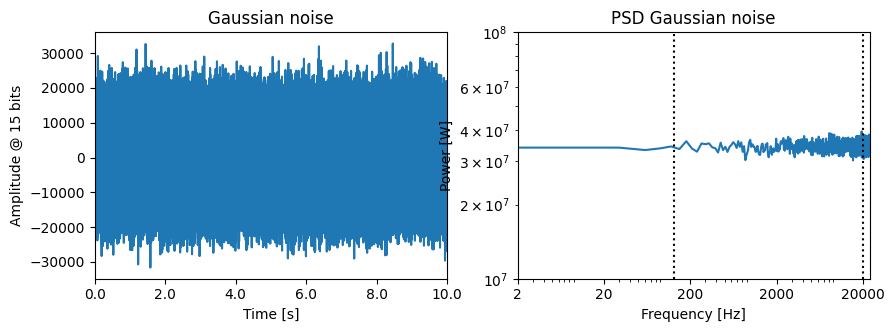

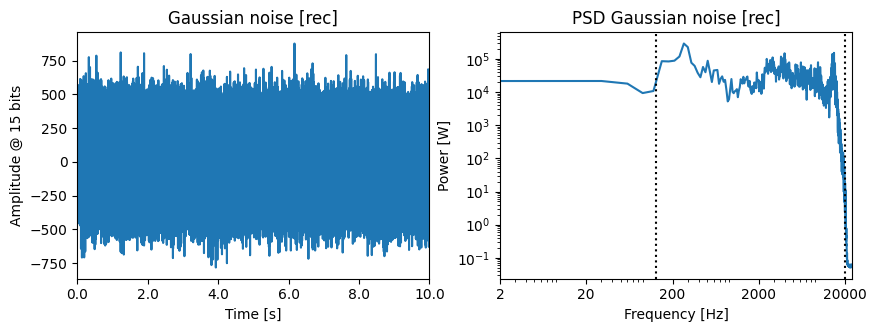

In [14]:
""" generar ruido blanco gaussiano
t = np.linspace(start=0, stop=n_sec, num=n_sec*fs)
x6 = np.random.normal(loc=0, scale=1, size=n_sec*fs)
x6 = amplitude * x6 / np.max(x6)
scipy.io.wavfile.write("audio/original/gaussian_noise.wav", fs, x6.astype(np.int16))
"""
fs, x6 = scipy.io.wavfile.read("audio/excitaciones/gaussian_noise.wav") 

# Periodograma
N = len(x6)
L = N // 300
freq, Pxx, K = periodogram_averaging(x=x6, N=N, L=L, D=L//2)

figx6 = plot_audio(x6, fs, freq, Pxx, title="Gaussian noise")
figx6.axes[1].set_ylim(10**7,10**8)


""" Audio recorded with the microphone """
rate_mic, data_mic = scipy.io.wavfile.read(filename="audio/recordings/gaussian_noise_mic.wav")
offset = 45500 # a ojo
y6 = data_mic[offset:offset+10*rate_mic]

# Periodograma
N = len(y6)
L = N // 300
freq, Pxx, K = periodogram_averaging(x=y6, N=N, L=L, D=L//2)
figy6 = plot_audio(x=y6, fs=rate_mic, freq=freq, Pxx=Pxx, title="Gaussian noise [rec]")


display(figx6, figy6)


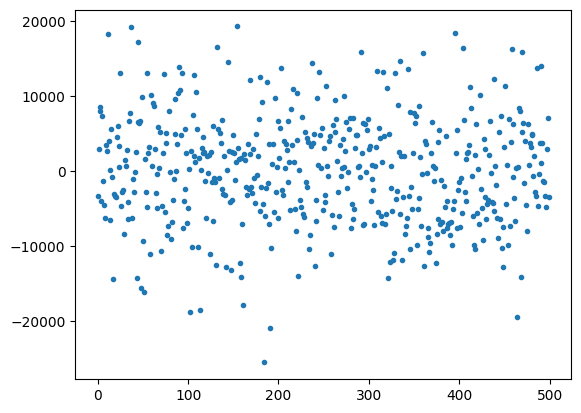

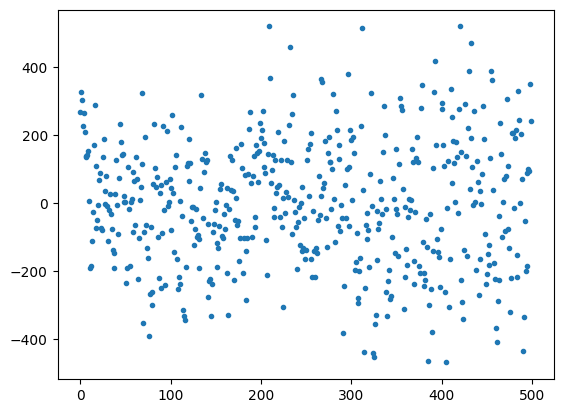

In [15]:
plt.plot(x6[:500], "."); plt.show()
plt.plot(data_mic[90600:91100], "."); plt.show()

## 2. Opinión: ¿cuál excitación dará la mejor estimación de h(n)?

En primer lugar, descarto la onda cuadrada. Intuyo que por tener cambios muy rápidos, la señal de sonido física no puede ser emitida de forma precisa por el parlante ni recibida correctamente por el micrófono. Eso explicaría por qué el espectro de la señal grabada es tan distinto de respecto de la onda cuadrada original.

Los barridos tienen la ventaja de no tener variaciones tan bruscas y de tener un espectro bastante plano en el rango audible. El barrido exponencial recorre todas las frecuencias de una forma que es más congruente con el funcionamiento natural del oído humano, por lo tanto, se podría pensar que tal excitación logrará captar mejor los artefactos del ambiente que hacen a la percepción humana del sonido. En ese sentido, creo que la estimación de h(n) dada por el barrido exponencial será mejor que la obtenida con el barrido lineal.

El ruido blanco gaussiano también es plano y además podemos observar que el espectro de la señal grabada es mucho más similar a la original que los casos de barrido exponencial y lineal, donde se observa una caída más pronunciada entre 2000 y 20000 Hz. De hecho, sucede lo mismo en las señales de voz y de música.
Con lo visto hasta acá, y siendo que la identificación de sistemas actúa para maximizar la correlación entre la señal estimada y la señal deseada, yo espero que el ruido blanco gaussiano me dé la mejor estimación de h(n).

## 3. Orden óptimo

In [16]:
def get_estimators(x, y):
    sigma2y = np.var(y)
    rxx = scipy.signal.correlate(x,x, mode="same", method="auto")
    rxy = scipy.signal.correlate(x,y, mode="same", method="auto")

    rxx_ = rxx[len(rxx)//2:]
    rxy_ = rxy[len(rxy)//2:]

    rxx = np.array([rxx_[i]/(len(rxx)-i) for i in range(len(rxx_))])
    rxy = np.array([rxy_[i]/(len(rxy)-i) for i in range(len(rxy_))])

    return sigma2y, rxx, rxy

### Estimar autocorrelación y correlación cruzada

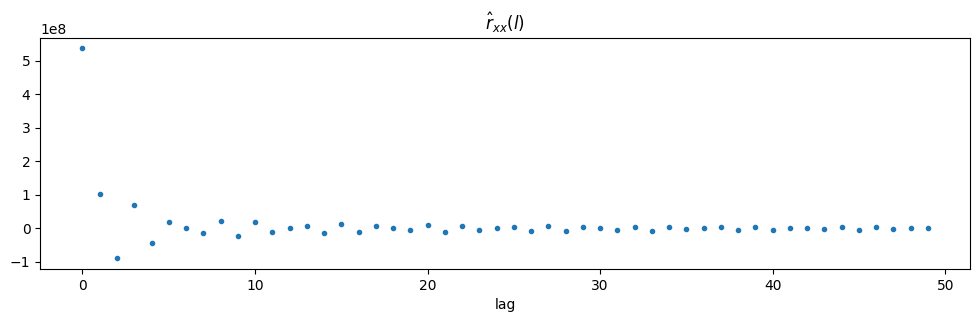

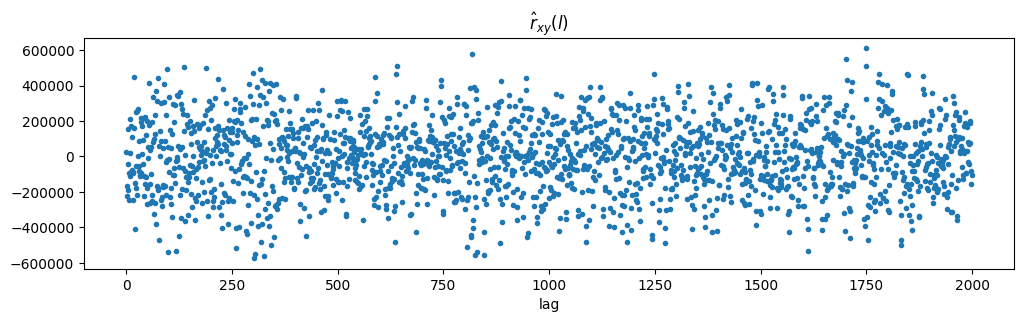

In [17]:
x=x4 - np.mean(x4)
y=y4 - np.mean(y4)
sigma2y, rxx, rxy = get_estimators(x=x, y=y)

plt.figure(figsize=(12,3))
plt.plot(rxx[:50], ".")
plt.title("$\hat r_{xx}(l)$")
plt.xlabel("lag")
plt.show()

plt.figure(figsize=(12,3))
plt.plot(rxy[:2000], ".")
plt.title("$\hat r_{xy}(l)$")
plt.xlabel("lag")
plt.show()

In [18]:
def optimum_filter(sigma2y: float, R:np.array, p:np.array) -> np.array:
    wo = scipy.linalg.inv(R).dot(p)
    Jo = sigma2y - p.dot(wo)
    return wo, Jo

In [19]:
# 1. Selección del modelo
# El modelo es un suistema AZ de orden M
M = 3000 # orden

# 2. Estimación de los parámetros del modelo
# Básicamente es estimar R y p
col = rxx[:M]
R = scipy.linalg.toeplitz(c=col)
p = rxy[:M]

if not np.all(np.linalg.eigvals(R) > 0):
    print("R no es definida positiva")

# 3. Validación del modelo
sigma2y = np.var(y)
wo, Jo = optimum_filter(sigma2y, R, p)
print(Jo)
print("MSE normalizado = " +  f"{Jo/sigma2y}")




73880.24272732984
MSE normalizado = 0.2505594917429487


In [20]:
def calc_cost_function(orders: list, sigma2y: float, rxx: np.array, rxy: np.array):
    mse_norm_arr = []
    Jo_arr = []
    for M in orders:
        col = rxx[:M]
        R = scipy.linalg.toeplitz(c=col)
        p = rxy[:M]
        wo, Jo = optimum_filter(sigma2y, R, p)
        mse_norm = Jo / sigma2y
        Jo_arr.append(Jo)
        mse_norm_arr.append(Jo / sigma2y)
    return Jo_arr, mse_norm_arr

def plot_cost_function(mse_norm_arr, Jo_arr, orders):
    fig = plt.figure(figsize=(10, 3.2))
    ax1 = fig.add_subplot(1, 2, 1)
    ax1.plot(mse_norm_arr, "x")
    ax1.set_title("MSE normalizado")
    ax1.set_xlabel("$M$")
    ax1.set_ylabel("$ℰ(M)$")
    ax1.set_xticks(ticks=[i for i in range(len(orders))], labels=[f"{i}" for i in orders], rotation=45)

    ax2 = fig.add_subplot(1, 2, 2)
    ax2.plot(Jo_arr, "x")
    ax2.set_title("Función de costo")
    ax2.set_xlabel("$M$")
    ax2.set_ylabel("$J_o(M)$")
    ax2.set_xticks(ticks=[i for i in range(len(orders))], labels=[f"{i}" for i in orders], rotation=45)
    plt.close()

    table = "M\t" + "\t".join(map(lambda x: f"{x:.03f}",mse_norm_arr)) + "\n" + "ℰ(M)\t" + "\t".join(map(str,orders))
    
    return fig, table

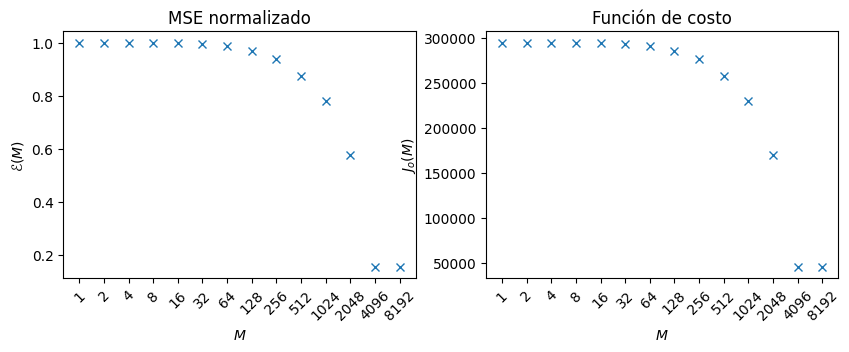

M	1.000	1.000	0.999	0.999	0.998	0.994	0.988	0.967	0.940	0.875	0.778	0.574	0.155	0.155
ℰ(M)	1	2	4	8	16	32	64	128	256	512	1024	2048	4096	8192


In [21]:
orders=[2**i for i in range(14)]
Jo_arr, mse_norm_arr = calc_cost_function(orders, sigma2y, rxx, rxy)
fig, table = plot_cost_function(mse_norm_arr, Jo_arr, orders)

display(fig)
print(table)

Se sigue que el M óptimo está entre 2048 y 4096

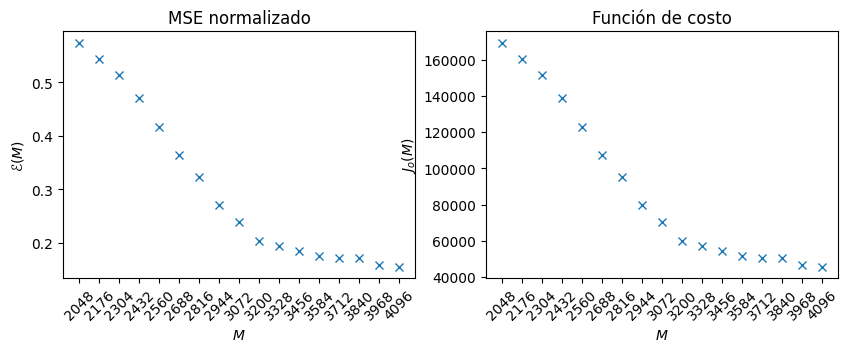

M	0.574	0.544	0.513	0.471	0.416	0.364	0.322	0.270	0.239	0.203	0.193	0.184	0.175	0.172	0.171	0.158	0.155
ℰ(M)	2048	2176	2304	2432	2560	2688	2816	2944	3072	3200	3328	3456	3584	3712	3840	3968	4096


In [22]:
orders = [i for i in range(2048, 4097, 128)]
Jo_arr, mse_norm_arr = calc_cost_function(orders, sigma2y, rxx, rxy)
fig, table = plot_cost_function(mse_norm_arr, Jo_arr, orders)

display(fig)
print(table)

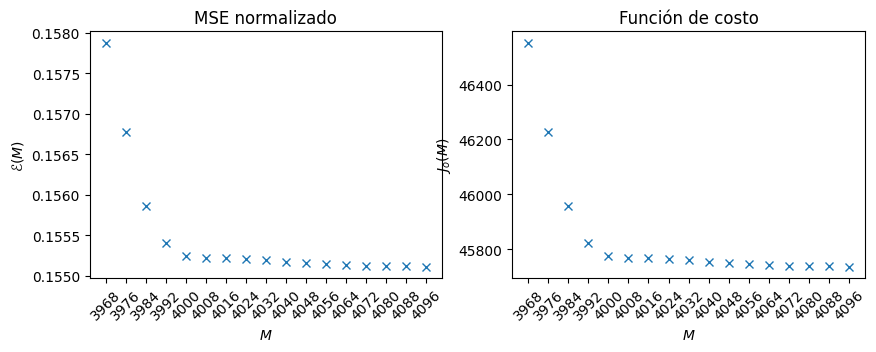

M	0.158	0.157	0.156	0.155	0.155	0.155	0.155	0.155	0.155	0.155	0.155	0.155	0.155	0.155	0.155	0.155	0.155
ℰ(M)	3968	3976	3984	3992	4000	4008	4016	4024	4032	4040	4048	4056	4064	4072	4080	4088	4096


In [23]:
orders = [i for i in range(3968, 4097, 8)]
Jo_arr, mse_norm_arr = calc_cost_function(orders, sigma2y, rxx, rxy)
fig, table = plot_cost_function(mse_norm_arr, Jo_arr, orders)

display(fig)
print(table)

Se concluye M=4000 como el orden óptimo para el barrido lineal en frecuencia.

## 4. Estimación de $h_i(n)$

### $h_4(n)$

Jo = 45775.602	ℰ = 0.155


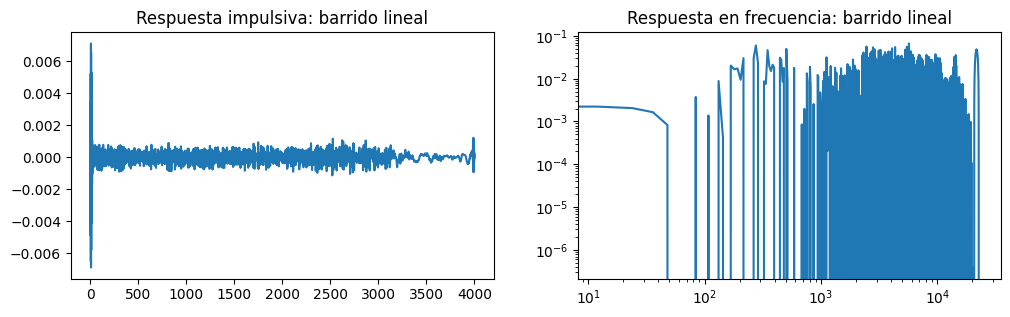

In [24]:
M = 4000

col = rxx[:M]
R = scipy.linalg.toeplitz(c=col)
p = rxy[:M]
wo, Jo = optimum_filter(sigma2y, R, p)
h4 = wo

print(f"Jo = {Jo:.03f}\tℰ = {Jo/sigma2y:.03f}")

def plot_impulse_response(h, title):
    fig = plt.figure(figsize=(12,3.2))
    ax1 = fig.add_subplot(1,2,1)
    ax1.plot(h)
    ax1.set_title("Respuesta impulsiva: " + title)
    H = fftshift(np.real(fft(h)))
    freq = fftshift(fftfreq(len(h), d=1/fs))
    ax2 = fig.add_subplot(1,2,2)
    ax2.loglog(freq[len(freq)//2:], H[len(freq)//2:])
    ax2.set_title("Respuesta en frecuencia: " + title)
    plt.close()
    return fig

figh4 = plot_impulse_response(h4, "barrido lineal")
display(figh4)

In [25]:
y4_hat = scipy.signal.convolve(in1=x4-np.mean(x4), in2=h4, mode="same")
scipy.io.wavfile.write("audio/estimaciones/linear_sine_sweep_hat.wav", fs, y4_hat.astype(np.int16))

### $h_1(n)$ Voz

Jo1 = 23635.751	ℰ = 0.960


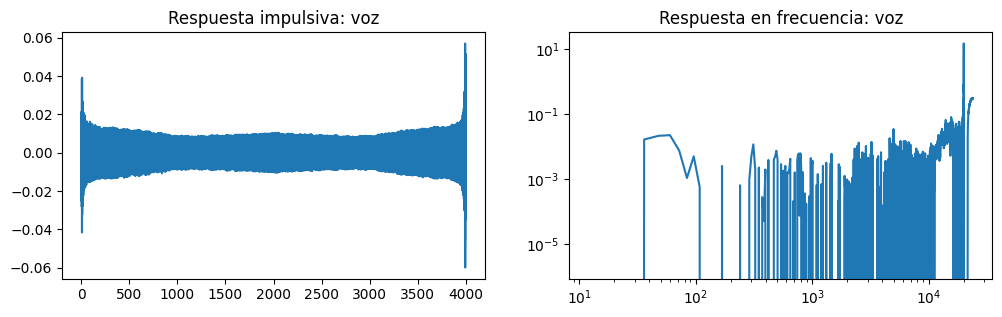

In [26]:
sigma2y1, rx1, rx1y1 = get_estimators(x=x1-np.mean(x1), y=y1-np.mean(y1))

col = rx1[:M]
R1 = scipy.linalg.toeplitz(c=col)
p1 = rx1y1[:M]
wo1, Jo1 = optimum_filter(sigma2y1, R1, p1)
h1 = wo1

print(f"Jo1 = {Jo1:.03f}\tℰ = {Jo1/sigma2y1:.03f}")

figh1 = plot_impulse_response(h1, "voz")
display(figh1)

In [29]:
y1_hat = scipy.signal.convolve(in1=x1, in2=h1, mode="same")
scipy.io.wavfile.write("audio/estimaciones/voices_hat.wav", fs, y1_hat.astype(np.int16))

### $h_2(n)$

Jo2 = 3072.759	ℰ = 0.966


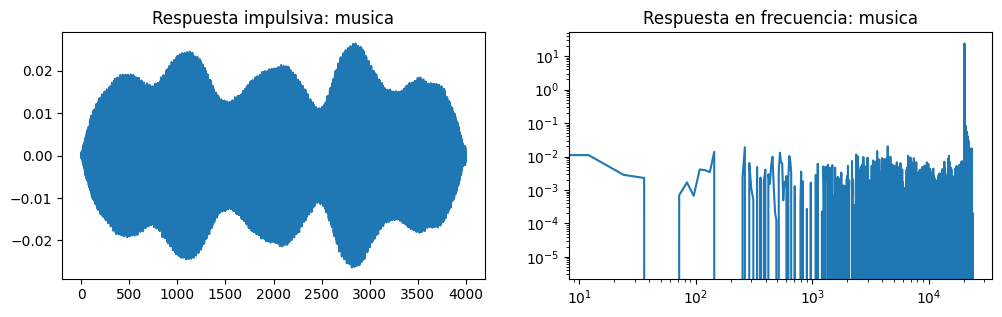

In [35]:
sigma2y2, rx2, rx2y2 = get_estimators(x=x2-np.mean(x2), y=y2-np.mean(y2))

col = rx2[:M]
R2 = scipy.linalg.toeplitz(c=col)
p2 = rx2y2[:M]
wo2, Jo2 = optimum_filter(sigma2y2, R2, p2)
h2 = wo2

print(f"Jo2 = {Jo2:.03f}\tℰ = {Jo2/sigma2y2:.03f}")

figh2 = plot_impulse_response(h2, "musica")
display(figh2)

In [36]:
y2_hat = scipy.signal.convolve(in1=x2, in2=h2, mode="same")
scipy.io.wavfile.write("audio/estimaciones/newyork_hat.wav", fs, y2_hat.astype(np.int16))

### $h_3(n)$

Jo3 = 352710.000	ℰ = 3.987


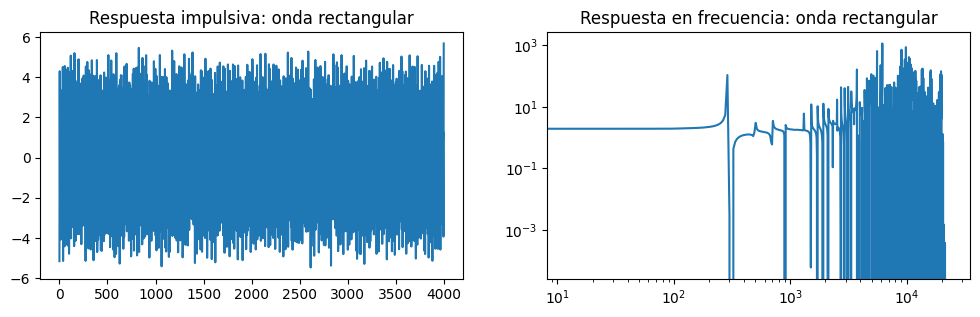

In [37]:
sigma2y3, rx3, rx3y3 = get_estimators(x=x3-np.mean(x3), y=y3-np.mean(y3))

col = rx3[:M]
R3 = scipy.linalg.toeplitz(c=col)
p3 = rx3y3[:M]
wo3, Jo3 = optimum_filter(sigma2y3, R3, p3)
h3 = wo3

print(f"Jo3 = {Jo3:.03f}\tℰ = {Jo3/sigma2y3:.03f}")

figh3 = plot_impulse_response(h3, "onda rectangular")
display(figh3)

y3_hat = scipy.signal.convolve(in1=x3, in2=h3, mode="same")
scipy.io.wavfile.write("audio/estimaciones/square_wave_hat.wav", fs, y3_hat.astype(np.int16))


### $h_5(n)$

Jo5 = 17939.085	ℰ = 0.056


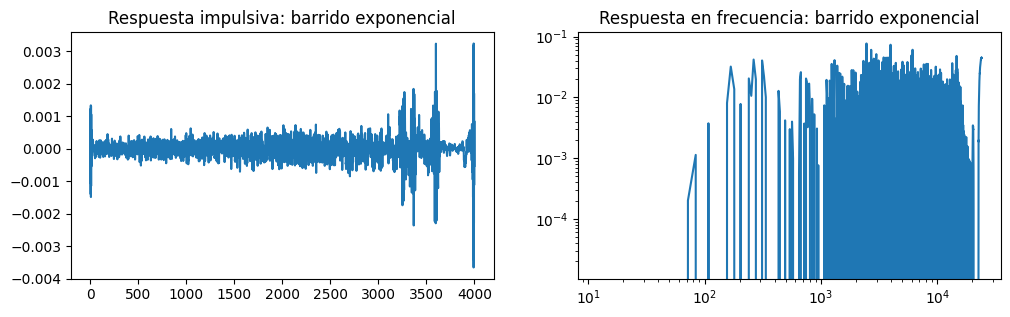

In [38]:
sigma2y5, rx5, rx5y5 = get_estimators(x=x5-np.mean(x5), y=y5-np.mean(y5))

col = rx5[:M]
R5 = scipy.linalg.toeplitz(c=col)
p5 = rx5y5[:M]
wo5, Jo5 = optimum_filter(sigma2y5, R5, p5)
h5 = wo5

print(f"Jo5 = {Jo5:.03f}\tℰ = {Jo5/sigma2y5:.03f}")

figh5 = plot_impulse_response(h5, "barrido exponencial")
display(figh5)

y5_hat = scipy.signal.convolve(in1=x5, in2=h5, mode="same")
scipy.io.wavfile.write("audio/estimaciones/exp_sine_sweep_hat.wav", fs, y5_hat.astype(np.int16))

El MSE normalizado obtenido para el barrido exponencial es muy bajo (0.056). Se puede apreciar que suenan realmente muy parecido, lo cual es sorprendente dado que la excitación se escucha notablemente diferente. Esto indica que el filtro obtenido con el barrido exponencial en frecuencia modela correctamente la habitación.

In [39]:
# Excitación
playsound("audio/excitaciones/exp_sine_sweep.wav")

In [40]:
# Grabación
playsound("audio/recordings/exp_sine_sweep_mic.wav")

In [41]:
# Estimación de la grabación
playsound("audio/estimaciones/exp_sine_sweep_hat.wav")

### $h_6(n)$

Jo6 = 29763.507	ℰ = 0.992


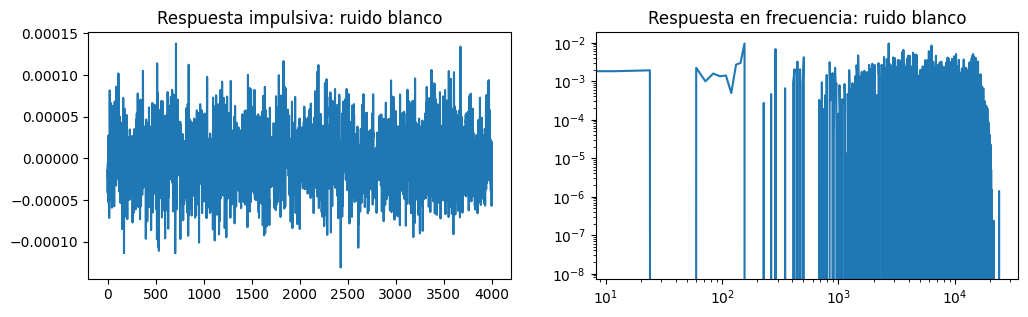

In [42]:
sigma2y6, rx6, rx6y6 = get_estimators(x=x6-np.mean(x6), y=y6-np.mean(y6))

col = rx6[:M]
R6 = scipy.linalg.toeplitz(c=col)
p6 = rx6y6[:M]
wo6, Jo6 = optimum_filter(sigma2y6, R6, p6)
h6 = wo6

print(f"Jo6 = {Jo6:.03f}\tℰ = {Jo6/sigma2y6:.03f}")

figh6 = plot_impulse_response(h6, "ruido blanco")
display(figh6)

y6_hat = scipy.signal.convolve(in1=x6, in2=h6, mode="same")
scipy.io.wavfile.write("audio/estimaciones/gaussian_noise_hat.wav", fs, y6_hat.astype(np.int16))

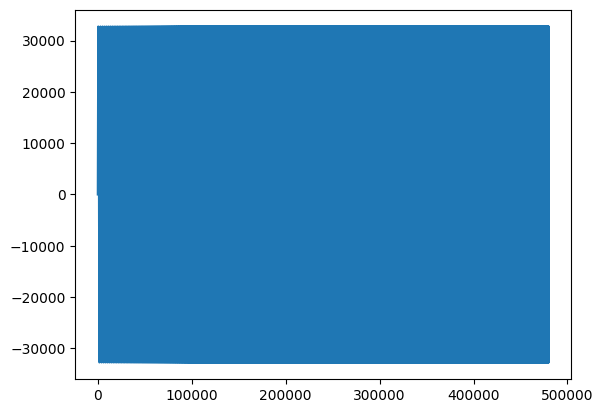

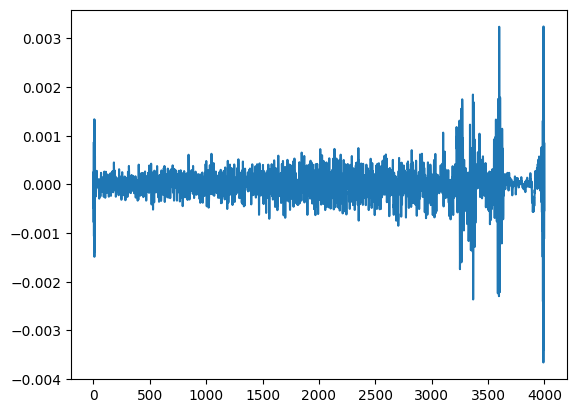

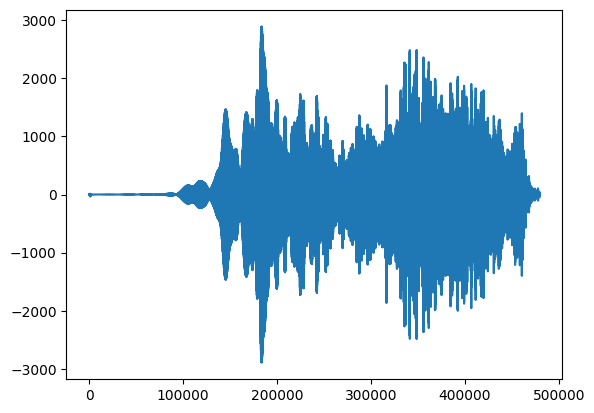

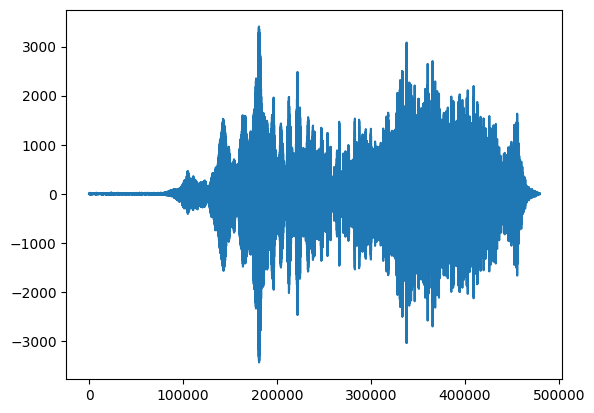

In [57]:
plt.plot(x5); plt.show()
plt.plot(h5);plt.show()
plt.plot(y5_hat); plt.show()
plt.plot(y5); plt.show()

## Música y voz con el filtro $h_5(n)$

In [44]:
y2_hat_h5 = scipy.signal.convolve(in1=x2, in2=h5, mode="same")
scipy.io.wavfile.write("audio/estimaciones/newyork_hat_h5.wav", fs, y2_hat_h5.astype(np.int16))

y2_hat_h4 = scipy.signal.convolve(in1=x2, in2=h4, mode="same")
scipy.io.wavfile.write("audio/estimaciones/newyork_hat_h4.wav", fs, y2_hat_h4.astype(np.int16))

In [45]:
playsound("audio/excitaciones/newyork_right.wav")

In [46]:
playsound("audio/recordings/newyork_mic.wav")

In [47]:
playsound("audio/estimaciones/newyork_hat_h5.wav")

Perceptualmente se aprecia la semejanza entre la señal grabada y la señal sintetizada a partir de la excitación con el filtro $h_5(n)$ obtenido a partir de aplicar identificación de sistemas usando como señal de datos y señal deseado el barrido exponencial de frecuencia y su grabación, respectivamente.

Como extra, podemos ver lo que pasa con la señal de voz. Si bien se observa cierto parecido, es fácil distingir la grabación de la estimación. No obstante, vale la pena apreciar que hay cierta similitud, por ejemplo se escucha la reverberación, de forma que al escuchar la señal sintética da la sensación de estar en la habitación sin auriculares.  

No hay, a mi oido, diferencias perceptibles del barrido exponencial respecto del barrido lineal en los ejemplos mostrados. No obstante, con el barrido exponencial se logró un menor MSE, de forma que $h_5(n)$ es el mejor filtro.

In [54]:
y1_hat_h5 = scipy.signal.convolve(in1=x1, in2=h5, mode="same")
scipy.io.wavfile.write("audio/estimaciones/voices_hat_h5.wav", fs, y1_hat_h5.astype(np.int16))


# La estimación con h4 también se percibe similar.
y1_hat_h4 = scipy.signal.convolve(in1=x1, in2=h4, mode="same")
scipy.io.wavfile.write("audio/estimaciones/voices_hat_h4.wav", fs, y1_hat_h4.astype(np.int16))

In [49]:
#playsound("audio/excitaciones/voices_right.wav")

In [52]:
#playsound("audio/recordings/voices_mic.wav")

In [ ]:
#playsound("audio/estimaciones/voices_hat_h5.wav")